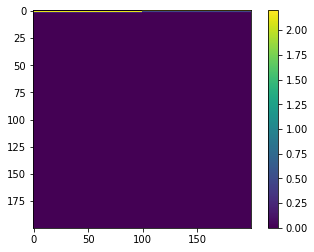

In [205]:
# Make 3 classes

import numpy as np
import matplotlib.pyplot as plt

dim2 = 200
dim = dim2*dim2
c1c0 = [(0,1e4)]
c1c1 = [(1e4,2e4)]
c1c2 = [(100,300)]
c1c3 = [(100,300)]
c2c1 = c1c2
c2c2 = [(300,400)]
c2c3 = [(100,300)]
c3c1 = c1c3
c3c2 = c2c3
c3c3 = [(500,600)]

c1p = np.zeros(dim)
c2p = np.zeros(dim)
c3p = np.zeros(dim)
c1n = np.zeros(dim)
c2n = np.zeros(dim)
c3n = np.zeros(dim)

for j,cp,cn,rs in [(0,c1p, c1n, [c1c1,c1c2,c1c3]),(1,c2p, c2n, [c2c1,c2c2,c2c3]),(2,c3p, c3n,[c3c1,c3c2,c3c3])]:
    for i,same in enumerate(rs):
        for a,b in same:
            cp[a:b] = 1+0.2
            cn[a:b] = -1+0.2 if i == j else 1

plt.imshow((c2p+c2n).reshape(dim2,dim2))
plt.colorbar()
plt.show()

In [222]:
def instantiate(c, sigma):
    return c+np.random.normal(0,sigma,size=c.shape[0])

import math

sigma = 1

gN = 50*2
gN8 = math.floor((3/10)*gN)
gN9 = math.floor((6/10)*gN)

group1 = np.stack([instantiate(c1p, sigma) for i in range(gN>>1)] 
                  + [instantiate(c1n, sigma) for i in range(gN>>1)])
group2 = np.stack([instantiate(c2p, sigma) for i in range(gN>>1)] 
                  + [instantiate(c2n, sigma) for i in range(gN>>1)])
group3 = np.stack([instantiate(c3p, sigma) for i in range(gN>>1)] 
                  + [instantiate(c3n, sigma) for i in range(gN>>1)])

tr = np.concatenate([group1[:gN8], group2[:gN8], group3[:gN8]], axis=0)
v = np.concatenate([group1[gN8:gN9], group2[gN8:gN9], group3[gN8:gN9]], axis=0)
t = np.concatenate([group1[gN9:], group2[gN9:], group3[gN9:]], axis=0)

np_all = np.concatenate([tr, v, t])

print(np_all.shape)
print('Complete')

(300, 40000)
Complete


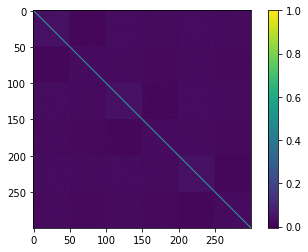

In [223]:
plt.imshow(np.corrcoef(np.concatenate([group1, group2, group3])))
plt.colorbar()
plt.show()

In [224]:
br = np.repeat([[1,0,0]],gN8,axis=0)
bv = np.repeat([[1,0,0]],gN9-gN8,axis=0)
bt = np.repeat([[1,0,0]],gN-gN9,axis=0)

yr = np.concatenate([br, br[:,[1,0,2]], br[:,[1,2,0]]])
yv = np.concatenate([bv, bv[:,[1,0,2]], bv[:,[1,2,0]]])
ye = np.concatenate([bt, bt[:,[1,0,2]], bt[:,[1,2,0]]])

yt = np.concatenate([yr, yv, ye])

print(yr.shape)
print(yv.shape)
print(ye.shape)
print(yt.shape)

(90, 3)
(90, 3)
(120, 3)
(300, 3)


In [225]:
perm = np.random.permutation(gN*3)
np_all = np_all[perm]
yt = yt[perm]

print('Complete')

Complete


In [226]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv
import time

ypred_gcn = []

def arith(n):
    return int(n*(n+1)/2)

class GCN(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(GCN, self).__init__()
        self.gcn = []
        for i in range(2*nTgt):
            self.gcn.append(DenseGCNConv(dim,40).float().cuda())
            self.gcn.append(DenseGCNConv(40,3).float().cuda())
        self.gcn = nn.ModuleList(self.gcn)
        self.dp = nn.Dropout(p=dp)

    def forward(self, x):
        e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.gcn[2*i](x[:,i,:],e)).squeeze()
            y = self.gcn[2*i+1](y,e).squeeze()
            res.append(y)
        return res

class MLP(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(MLP, self).__init__()
        self.lin = []
        for i in range(2*nTgt):
            self.lin.append(nn.Linear(dim,100).float().cuda())
            self.lin.append(nn.Linear(100,3).float().cuda())
        self.lin = nn.ModuleList(self.lin)
        self.dp = nn.Dropout(p=dp)

    def forward(self, x):
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.lin[2*i](x[:,i,:])).squeeze()
            y = self.lin[2*i+1](y).squeeze()
            res.append(y)
        return res

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res = model(X)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss, avg

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

nEpochs = 10000
pPeriod = 100
thresh = 0.01

rmse = []

for i in range(10):
    validLoss = []

    gcn0 = MLP(1, 0.5)
    params = list(gcn0.parameters())
    optim = torch.optim.Adam(params, lr=2e-4, weight_decay=2e-4)

#     trainIdcs = np.arange(gN8*3)[rand_tr]
#     vIdcs = np.arange(gN8*3,gN9*3)[rand_v]
#     validIdcs = np.concatenate([trainIdcs, vIdcs])
#     testIdcs = np.arange(gN9*3,gN*3)[rand_t]

#     Xtr = torch.from_numpy(tr).unsqueeze(1).cuda().float()
#     Xv = torch.from_numpy(np.concatenate([tr, v])).unsqueeze(1).cuda().float()
#     X = torch.from_numpy(np.concatenate([tr, v, t])).unsqueeze(1).cuda().float()

    X = torch.from_numpy(np_all).unsqueeze(1).float().cuda()
    
    trainIdcs = np.arange(gN8*3)
    vIdcs = np.arange(gN8*3,gN9*3)
    validIdcs = np.concatenate([trainIdcs, vIdcs])
    testIdcs = np.arange(gN9*3,gN*3)

    # Xt.requires_grad_(True)

    val = torch.from_numpy(yt).cuda().float()

    for epoch in range(nEpochs):
    #     Xt.grad = None
        optim.zero_grad()
        res = gcn0(X[trainIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        loss0 = 0
        for r in res + [avg]:
            loss0 += ceLoss(r, val[trainIdcs])/(len(res)+1)
        loss = torch.stack([loss0])
        loss += 1000*torch.mean(torch.abs(gcn0.lin[0].weight))
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
#             print(f'epoch {epoch} loss={(float(loss0))}')
            lossV, _ = validate(gcn0, X[validIdcs], val[validIdcs], vIdcs)
            if len(validLoss) == 0 or lossV > max(validLoss):
#                 print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(gcn0.state_dict(), '../../Work/LatentSim/gcn.pyt')
    #                     finalRes[i] = Xt.grad.detach()
            validLoss.append(lossV)
            if loss0 < thresh:
                print('Early stopping')
                break

    print('Finished training')

    gcn0.load_state_dict(torch.load('../../Work/LatentSim/gcn.pyt'))
    loss0, corr = validate(gcn0, X, val, testIdcs)
    ypred_gcn.append(corr.detach().cpu().numpy())

    rmse.append((float(loss0)))
    print(rmse[-1])
    
print('---')
print(np.mean(rmse))
print(np.std(rmse))

Early stopping
Finished training
0.3750000298023224
Early stopping
Finished training
0.40833336114883423
Early stopping
Finished training
0.3583333492279053
Early stopping
Finished training
0.36666667461395264
Early stopping
Finished training
0.3500000238418579
Early stopping
Finished training
0.40833336114883423
Early stopping
Finished training
0.3916666805744171
Early stopping
Finished training
0.4166666865348816
Early stopping
Finished training
0.3916666805744171
Early stopping
Finished training
0.3500000238418579
---
0.38166668713092805
0.023804762513498716


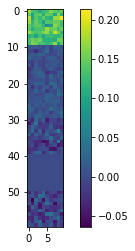

In [150]:
plt.imshow(heatmap(torch.sum(gcn0.lin[0].weight[:,:].detach(), dim=0), 200)[0:3,:].reshape(60,-1))
plt.colorbar()
plt.show()

In [230]:
import torch
import torch.nn as nn
import torch.nn.functional as F

rmse = []
ypred_sim = []

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, inp, dp=0.5, edp=0.1):
        super(LatSim, self).__init__()
        self.active = nn.Parameter(1e-2*torch.randn(nTgts,inp.shape[-1],300).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
    
    def getLatentsAndEdges(self, x, i):
        e = 1e-10
        y = torch.einsum('ac,ce->ae', x, self.active[i])
        e = e+y@y.T
        return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(self.active.shape[0]):
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.edp(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss, avg.detach().cpu().numpy()

nEpochs = 500
pPeriod = 10
thresh = 0.01

# Xtr = torch.from_numpy(tr).unsqueeze(1).cuda().float()
# Xv = torch.from_numpy(np.concatenate([tr, v])).unsqueeze(1).cuda().float()
# X = torch.from_numpy(np.concatenate([tr, v, t])).unsqueeze(1).cuda().float()
X = torch.from_numpy(np_all).unsqueeze(1).float().cuda()

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

for i in range(10):
    sim = LatSim(1, X, 0.5, 0.1) # 0.2 wrat, 0.1 other
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) 

    trainIdcs = np.arange(gN8*3)
    vIdcs = np.arange(gN8*3,gN9*3)
    validIdcs = np.concatenate([trainIdcs, vIdcs])
    testIdcs = np.arange(gN9*3,gN*3)

    # Xt.requires_grad_(True)

    var = torch.from_numpy(yt).cuda().float()

    trainLoss = []
    validLoss = []

    # vIdcs1 = np.arange(496,len(validIdcs))
    # vIdcs2 = validIdcs[496:]
    # vIdcs3 = np.concatenate([testIdcs, vIdcs2])
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, _ = sim(X[trainIdcs], var[trainIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        loss = 0
        for r in res + [avg]:
            loss += ceLoss(r, var[trainIdcs])
        loss = torch.stack([loss/(len(res)+1)])
#         loss += 100*torch.mean(torch.abs(sim.active[0]))
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
#             print(f'epoch {epoch} loss={(float(loss))}')
            lossV, _ = validate(sim, X[validIdcs], var[validIdcs], vIdcs)
            if len(validLoss) == 0 or lossV > max(validLoss):
#                 print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break

    print('Finished training')

    sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
    loss, avg = validate(sim, X, var, testIdcs)
    ypred_sim.append(avg)
    rmse.append(loss.cpu().numpy())
    print(rmse[-1])

print('---')
print(np.mean(rmse))
print(np.std(rmse))

Finished training
0.35833335
Finished training
0.39166668
Finished training
0.40833336
Finished training
0.40000004
Finished training
0.3166667
Finished training
0.4416667
Finished training
0.40833336
Finished training
0.43333337
Finished training
0.40000004
Finished training
0.4416667
---
0.40000004
0.03670453


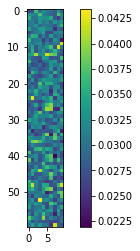

In [163]:
import matplotlib.pyplot as plt

def heatmap(cuda, d):
    v = cuda.detach().cpu().numpy().reshape(d,d)
    return v

plt.imshow(heatmap(torch.max(torch.abs(sim.active[0,:,:]), dim=1)[0], 200)[0:3,:].reshape(60,-1))
plt.colorbar()
plt.show()

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


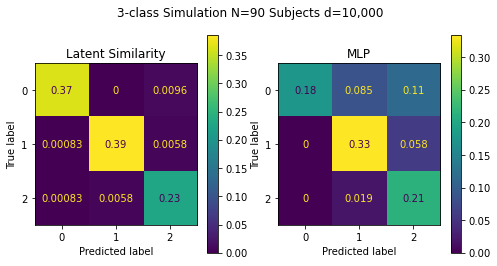

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(8,4))

ypred1 = np.argmax(np.concatenate([part[testIdcs] for part in ypred_sim]), axis=1)
ytrue = np.argmax(np.concatenate(20*[yt[testIdcs]]), axis=1)

ConfusionMatrixDisplay.from_predictions(ytrue, ypred1, normalize='all', ax=ax[0])
ax[0].set_title('Latent Similarity')

ypred2 = np.argmax(np.concatenate([part[testIdcs] for part in ypred_gcn]), axis=1)

ConfusionMatrixDisplay.from_predictions(ytrue, ypred2, normalize='all', ax=ax[1])
ax[1].set_title('MLP')

fig.suptitle('3-class Simulation N=90 Subjects d=10,000')
fig.show()
fig.savefig('../../Work/LatentSim/Simulations/3N90D100.png', format='png', bbox_inches='tight')

In [229]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500).fit(tr, np.argmax(yr, axis=1))
n = clf.predict(t) == np.argmax(ye, axis=1)
print(np.sum(n)/testIdcs.shape)

[0.]
